In [3]:
# notebooks/create_scenarios.ipynb
import sys
sys.path.append("..")   
from scripts.create_data import create_data_scenario
from scripts.logger import log_scenario_folder, mark_log_as_finished
import random
from datetime import datetime
from scripts.logger import create_new_id
import os

# Initialize logging ID
logs_id = create_new_id("scenario")

num_scenarios = 1
amount_aircraft = 20
probabilistic_type = 'custom'
probabilities_values_type = 'high'
training_or_testing = 'Temp'




if probabilistic_type == 'stochastic':
    amount_aircraft_disrupted = 0
    amount_aircraft_uncertain = 2
elif probabilistic_type == 'deterministic':
    amount_aircraft_disrupted = 2
    amount_aircraft_uncertain = 0
elif probabilistic_type == 'mixed':
    amount_aircraft_disrupted = 1
    amount_aircraft_uncertain = 1
else:
    amount_aircraft_disrupted = 3
    amount_aircraft_uncertain = 5



if probabilistic_type != 'deterministic':
    if probabilities_values_type == 'high':
        prob_lower_bound = 0.5
        prob_upper_bound = 0.9
    elif probabilities_values_type == 'low':
        prob_lower_bound = 0.1
        prob_upper_bound = 0.5
    elif probabilities_values_type == 'medium':
        prob_lower_bound = 0.3
        prob_upper_bound = 0.7
    else:
        raise ValueError(f"Invalid probabilities_values_type: {probabilities_values_type}")
else:
    prob_lower_bound = 0.0
    prob_upper_bound = 0.0
    probabilities_values_type = 'na'



# Define logging inputs
logging_inputs = {
    "num_scenarios": num_scenarios,
    "aircraft_range": (amount_aircraft, amount_aircraft),
    "amount_aircraft_disrupted": amount_aircraft_disrupted,
    "amount_aircraft_uncertain": amount_aircraft_uncertain,
    "average_flights_per_aircraft": 12,
    "std_dev_flights_per_aircraft": 1,
    "min_delta_start_unavailability": 120,
    "max_delta_start_unavailability": 480,
    "min_period_unavailability": 120,
    "max_period_unavailability": 480,
    "probability_range": (prob_lower_bound, prob_upper_bound),
    "probability_distribution": 'uniform',
    "clear_one_random_aircraft": True,
    "clear_random_flights": True,
    "switch_one_random_flight_to_the_cleared_aircraft": True,
    "first_flight_dep_time_range": (6, 8),
    "flight_length_range": (2, 5),
    "time_between_flights_range": (0, 1),
}

# Fixed inputs
template_folder = "../data/Template"
data_root_folder = f"../data/{training_or_testing}/{amount_aircraft}ac-{logging_inputs['num_scenarios']}-{probabilistic_type}-{probabilities_values_type}/"
airports = [
    'AMS', 'CDG', 'FRA', 'LHR', 'MAD', 'MUC', 'ORY', 'TXL', 'VIE', 'ZRH', 
    'BCN', 'BRU', 'CPH', 'DUB', 'IST'
]
aircraft_types = [
    {'Model': 'B737', 'Family': 'Boeing', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 
     'TurnRound': 30, 'Transit': 30, 'Orig': ['CFE'], 'Maint': ['NULL']},
]
config_dict = {
    'DelayCosts': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 100.0}],
    'CancellationCostsOutbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 500.0}],
    'CancellationCostsInbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 600.0}],
    'DowngradingCosts': [{'FromCabin': 'Business', 'ToCabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 200.0}],
    'PenaltyCosts': [200, 300, 400],
    'Weights': [1.0, 0.5, 0.2],
}

# Initialize outputs dictionary
logging_outputs = {}

# Function to generate scenarios
for i in range(1, logging_inputs["num_scenarios"] + 1):
    scenario_name = f'Scenario_{i:02d}'  # Dynamically generate scenario names
    recovery_start_date = datetime(2024, 9, random.randint(1, 30)).strftime('%d/%m/%y')
    recovery_start_time = f'{random.randint(5, 7)}:00'
    recovery_end_date = recovery_start_date
    recovery_end_time = f'{random.randint(20, 23)}:{random.choice(["00", "30"])}'

    # Call the function for each scenario
    data_folder, inputs, outputs = create_data_scenario(
        scenario_name=scenario_name,
        template_folder=template_folder,
        data_root_folder=data_root_folder,
        aircraft_types=aircraft_types,
        total_aircraft_range=logging_inputs["aircraft_range"],
        amount_aircraft_disrupted=logging_inputs["amount_aircraft_disrupted"],
        amount_aircraft_uncertain=logging_inputs["amount_aircraft_uncertain"],
        min_delta_start_unavailability=logging_inputs["min_delta_start_unavailability"],
        max_delta_start_unavailability=logging_inputs["max_delta_start_unavailability"],
        min_period_unavailability=logging_inputs["min_period_unavailability"],
        max_period_unavailability=logging_inputs["max_period_unavailability"],
        average_flights_per_aircraft=logging_inputs["average_flights_per_aircraft"],
        std_dev_flights_per_aircraft=logging_inputs["std_dev_flights_per_aircraft"],
        airports=airports,
        config_dict=config_dict,
        recovery_start_date=recovery_start_date,
        recovery_start_time=recovery_start_time,
        recovery_end_date=recovery_end_date,
        recovery_end_time=recovery_end_time,
        clear_one_random_aircraft=logging_inputs["clear_one_random_aircraft"],
        clear_random_flights=logging_inputs["clear_random_flights"],
        switch_one_random_flight_to_the_cleared_aircraft=logging_inputs["switch_one_random_flight_to_the_cleared_aircraft"],
        probability_range=logging_inputs["probability_range"],
        probability_distribution=logging_inputs["probability_distribution"],
        first_flight_dep_time_range=logging_inputs["first_flight_dep_time_range"],
        flight_length_range=logging_inputs["flight_length_range"],
        time_between_flights_range=logging_inputs["time_between_flights_range"],
    )

    # Add scenario outputs to logging_outputs
    logging_outputs[scenario_name] = outputs

# Define the full data_folder path (assuming all scenarios are in the same folder)
# If scenarios are in separate folders, adjust accordingly
# Here, since num_scenarios=1, it's straightforward
scenario_folder_path = os.path.join(data_root_folder, scenario_name)

# Log the scenarios
log_scenario_folder(
    logs_id=logs_id,
    scenario_folder_path=data_root_folder,
    inputs=logging_inputs,
    outputs=logging_outputs
)

# Mark the log as finished
mark_log_as_finished(logs_id, additional_info=data_root_folder)



Data creation for scenario Scenario_01 completed with 20 aircraft and 67 flights.
Scenario logged to ../logs/scenarios/scenario_folder_scenario_32.json
Marked logs_id scenario_32 as finished in ../logs/ids.json


### Visualize them

Processing scenario: Scenario_01
{'B737#17': {'StartDate': '16/09/24', 'StartTime': '14:52', 'EndDate': '16/09/24', 'EndTime': '17:29', 'Probability': 1.0}, 'B737#19': {'StartDate': '16/09/24', 'StartTime': '09:19', 'EndDate': '16/09/24', 'EndTime': '15:18', 'Probability': 1.0}, 'B737#5': {'StartDate': '16/09/24', 'StartTime': '09:11', 'EndDate': '16/09/24', 'EndTime': '15:54', 'Probability': 1.0}, 'B737#11': {'StartDate': '16/09/24', 'StartTime': '10:02', 'EndDate': '16/09/24', 'EndTime': '17:13', 'Probability': 0.86}, 'B737#9': {'StartDate': '16/09/24', 'StartTime': '13:49', 'EndDate': '16/09/24', 'EndTime': '17:41', 'Probability': 0.53}, 'B737#3': {'StartDate': '16/09/24', 'StartTime': '13:05', 'EndDate': '16/09/24', 'EndTime': '15:46', 'Probability': 0.64}, 'B737#4': {'StartDate': '16/09/24', 'StartTime': '13:19', 'EndDate': '16/09/24', 'EndTime': '15:23', 'Probability': 0.8}, 'B737#6': {'StartDate': '16/09/24', 'StartTime': '11:47', 'EndDate': '16/09/24', 'EndTime': '15:17', 'Prob

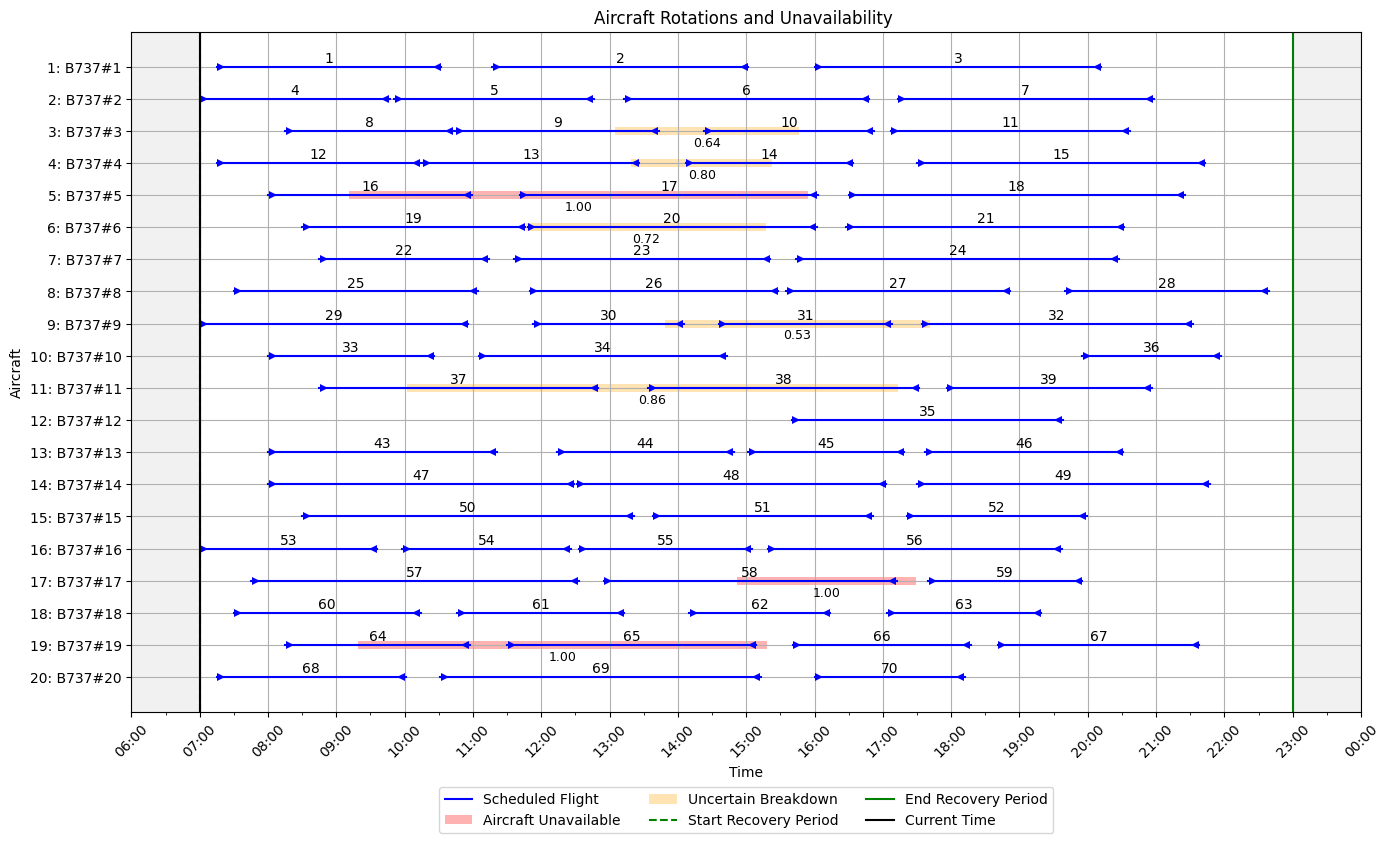

All scenarios processed successfully.


In [4]:
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
import os
from src.environment import AircraftDisruptionEnv
from datetime import datetime
from scripts.utils import print_state_nicely_proactive

env_type = 'proactive'


# Verify that the root folder exists
if not os.path.exists(data_root_folder):
    raise FileNotFoundError(f"The data root folder does not exist: {data_root_folder}")

# Get the list of scenarios, sorted by name in ascending order
scenarios = sorted(
    [scenario for scenario in os.listdir(data_root_folder) if os.path.isdir(os.path.join(data_root_folder, scenario))]
)
plotter_counter = 0
# Process each scenario
for scenario_name in scenarios:
    plotter_counter += 1
    if plotter_counter > 10:
        break

    scenario_path = os.path.join(data_root_folder, scenario_name)
    
    print(f"Processing scenario: {scenario_name}")

    # Verify that the scenario exists
    if not os.path.exists(scenario_path):
        print(f"Scenario {scenario_name} does not exist. Skipping...")
        continue

    # Load scenario data
    data_dict = load_scenario_data(scenario_path)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Print configuration details for verification
    # print(config_dict)

    # print alt_aircraft_dict
    print(alt_aircraft_dict)

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )
    # Print state with print_state_nicely_proactive
    print_state_nicely_proactive(env.state)
    
    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )



    # Define the recovery period based on provided configuration
    start_date = config_dict['RecoveryPeriod']['StartDate']
    start_time = config_dict['RecoveryPeriod']['StartTime']
    end_date = config_dict['RecoveryPeriod']['EndDate']
    end_time = config_dict['RecoveryPeriod']['EndTime']
    start_datetime = datetime.strptime(f"{start_date} {start_time}", '%d/%m/%y %H:%M')

    # Plot the state for the current scenario
    print(f"Plotting state for scenario: {scenario_name}")
    state_plotter.plot_state(flights_dict, [], [], set(), env.current_datetime)

print("All scenarios processed successfully.")
